Otsu threshold = 11.0


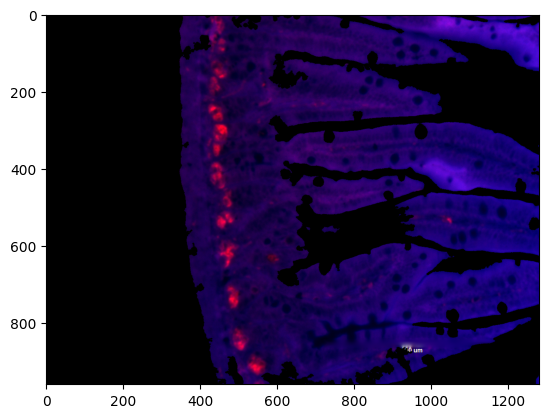

In [1]:
from pathlib import Path
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.stats import entropy as scipy_entropy
from scipy.ndimage import binary_fill_holes

# Cell 0: load and display a TIFF using tifffile

# explicit notebook path (adjust only if your notebook moved)
notebook = Path(r"C:\Users\admin\Documents\Pierre lab\projects\Colustrum-ABX\lysozyme stain quantification\code\component development\rebuild.ipynb")

# go up to the project folder "lysozyme stain quantification"
project_root = notebook.parent.parent.parent

# construct TIFF path relative to the project root
tif_path = project_root / "lysozyme images" / "Jej LYZ" / "G2" / "G2EL - 3.tif"

if not tif_path.exists():
    raise FileNotFoundError(f"TIFF not found: {tif_path.resolve()}")

def remove_rectangles( image, white_thresh=240, aspect_low=0.2, aspect_high=5.0,
                        dilation_kernel=(15, 15), inpaint_radius=15):
    """Remove rectangular artifacts from image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if image.ndim == 3 else image
    _, bm = cv2.threshold(gray, white_thresh, 255, cv2.THRESH_BINARY)
    cnts, _ = cv2.findContours(bm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w == 0 or h == 0: 
            continue
        ar = w / h
        if ar < aspect_low or ar > aspect_high:
            cv2.rectangle(mask, (x, y), (x+w, y+h), 255, -1)
            
    if not mask.any(): 
        return image.copy()
    mask = cv2.dilate(mask, np.ones(dilation_kernel, np.uint8), 1)
    bgr = image[..., ::-1]
    out = cv2.inpaint(bgr, mask, inpaint_radius, cv2.INPAINT_TELEA)
    return out[..., ::-1]

img = remove_rectangles(tifffile.imread(tif_path))  # loads numpy array

# compute Otsu threshold on a grayscale version, erode the mask and hole-fill it, then zero-out background pixels in img

# make a grayscale copy (match the conversion used later so variables stay consistent)
if img.ndim == 3 and img.shape[-1] in (3, 4):
    gray = cv2.cvtColor(img[..., :3], cv2.COLOR_RGB2GRAY)
else:
    gray = np.squeeze(img) if img.ndim >= 2 else img.copy()

gray_u8 = gray.astype(np.uint8)
otsu_thresh, _ = cv2.threshold(gray_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# initial binary mask (foreground True)
mask = gray_u8 > otsu_thresh

# erode the mask to remove small spurious foreground pixels
ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_eroded = cv2.erode((mask.astype(np.uint8) * 255), ker, iterations=1).astype(bool)

# fill holes in the eroded mask
mask_filled = binary_fill_holes(mask_eroded)

# update mask to the processed version
mask = mask_filled

# set background (where mask is False) to zero in the original img array
if img.ndim == 3 and img.shape[-1] in (3, 4):
    img[~mask] = 0
else:
    img[~mask] = 0
if img.ndim == 3 and img.shape[-1] in (3, 4):
    gray = cv2.cvtColor(img[..., :3], cv2.COLOR_RGB2GRAY)
else:
    gray = np.squeeze(img) if img.ndim >= 2 else img.copy()

gray_u8 = gray.astype(np.uint8)
otsu_thresh, _ = cv2.threshold(gray_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask = gray_u8 > otsu_thresh  # foreground True

# # set background (where mask is False) to zero in the original img array
# if img.ndim == 3 and img.shape[-1] in (3, 4):
#     img[~mask] = 0
# else:
#     img[~mask] = 0

print(f"Otsu threshold = {otsu_thresh}")
plt.imshow(img)



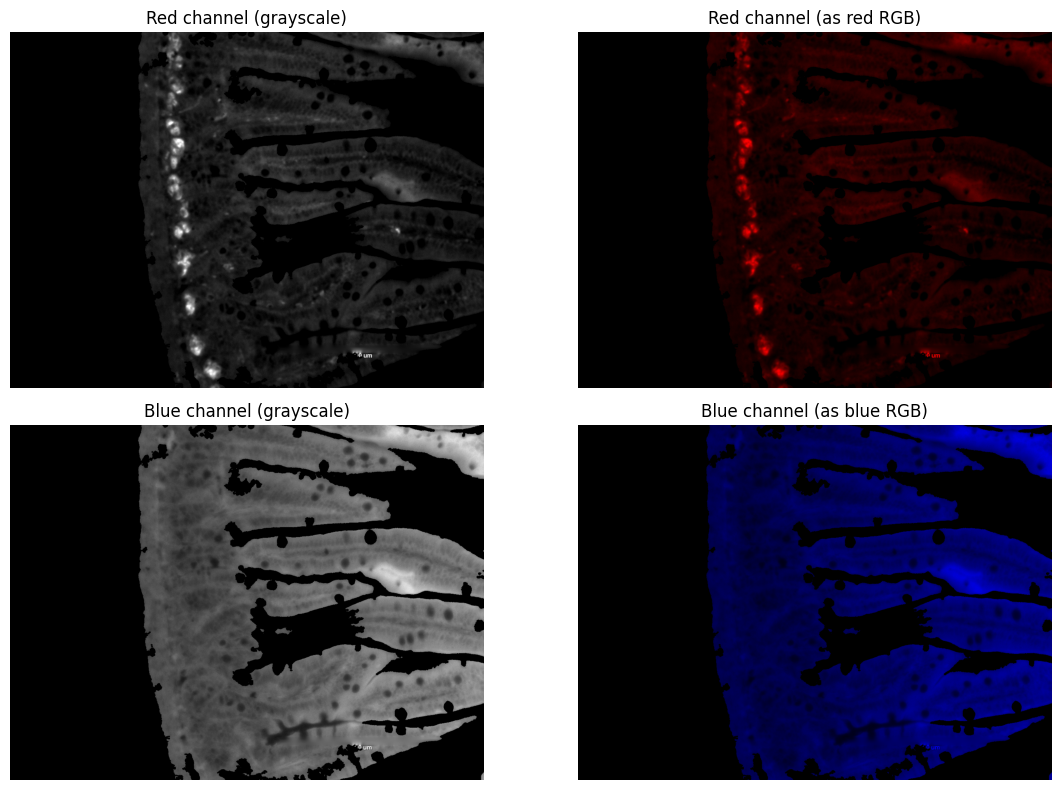

In [2]:
# extract channels (assuming img is HxWx3 in RGB order)
red_ch = img[..., 0]
blue_ch = img[..., 2]

# show channels: grayscale and as single-channel colored RGB
rgb_red = np.zeros_like(img)
rgb_red[..., 0] = red_ch
rgb_blue = np.zeros_like(img)
rgb_blue[..., 2] = blue_ch

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(red_ch, cmap="gray", vmin=0, vmax=255)
plt.title("Red channel (grayscale)")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(rgb_red)
plt.title("Red channel (as red RGB)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(blue_ch, cmap="gray", vmin=0, vmax=255)
plt.title("Blue channel (grayscale)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(rgb_blue)
plt.title("Blue channel (as blue RGB)")
plt.axis("off")

plt.tight_layout()
plt.show()

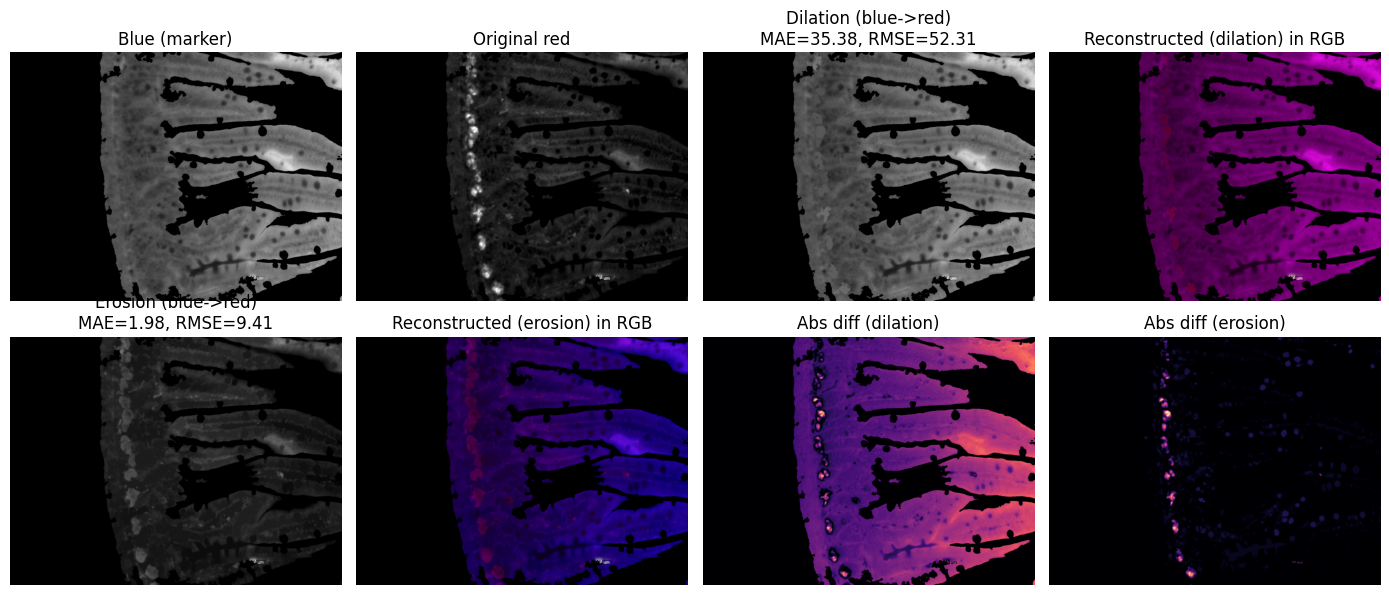

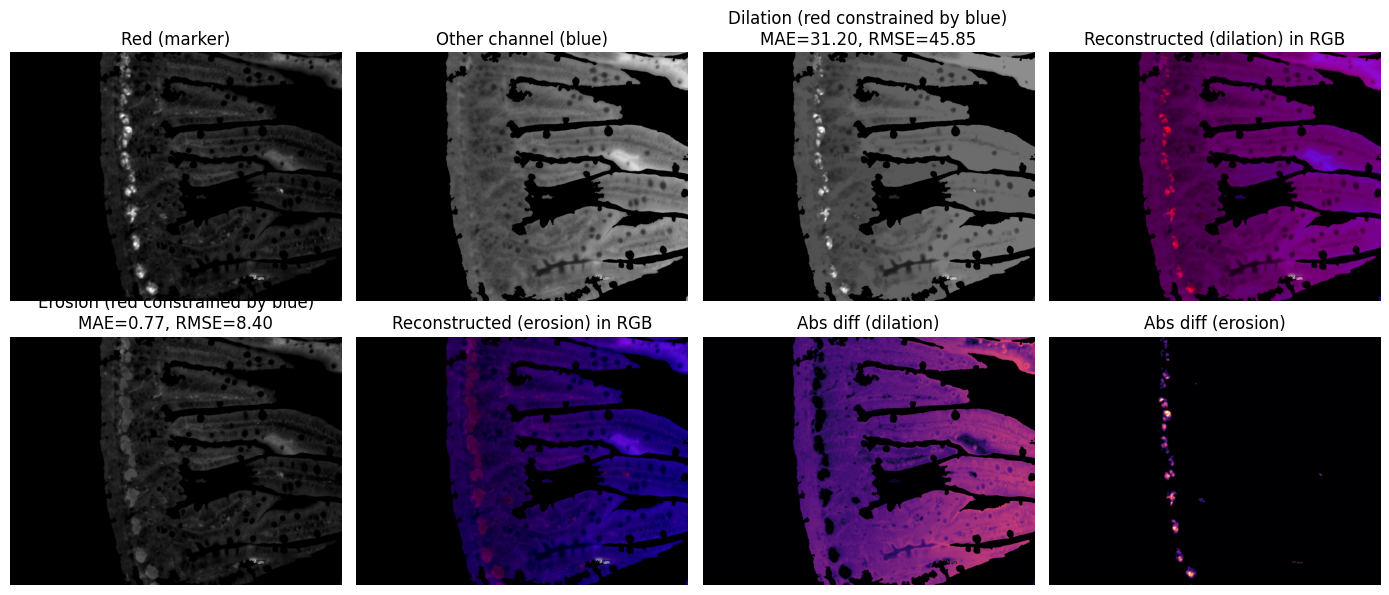

In [3]:
from skimage.morphology import reconstruction

# prepare both blue->red and red->blue reconstructions
disp = img[..., :3] if img.ndim == 3 and img.shape[-1] in (3, 4) else np.stack([img]*3, axis=-1)
marker_b = blue_ch.astype(np.float32)
other_b = red_ch.astype(np.float32)
mask_b_dilation = np.maximum(other_b, marker_b)   # for dilation: marker <= mask
mask_b_erosion  = np.minimum(other_b, marker_b)   # for erosion:  marker >= mask

marker_r = red_ch.astype(np.float32)
other_r = blue_ch.astype(np.float32)
mask_r_dilation = np.maximum(other_r, marker_r)
mask_r_erosion  = np.minimum(other_r, marker_r)

# morphological reconstructions
recon_d_blue = reconstruction(marker_b, mask_b_dilation, method="dilation")
recon_e_blue = reconstruction(marker_b, mask_b_erosion,  method="erosion")

recon_d_red  = reconstruction(marker_r, mask_r_dilation, method="dilation")
recon_e_red  = reconstruction(marker_r, mask_r_erosion,  method="erosion")

# convert back to uint8
recon_d_blue_u8 = np.clip(recon_d_blue, 0, 255).astype(np.uint8)
recon_e_blue_u8 = np.clip(recon_e_blue, 0, 255).astype(np.uint8)
recon_d_red_u8  = np.clip(recon_d_red,  0, 255).astype(np.uint8)
recon_e_red_u8  = np.clip(recon_e_red,  0, 255).astype(np.uint8)

# error metrics (compare all reconstructions to the original red channel)
def mae(a, b): return np.mean(np.abs(a.astype(np.int32) - b.astype(np.int32)))
def rmse(a, b): return np.sqrt(np.mean((a.astype(np.float32) - b.astype(np.float32))**2))

mae_db, rmse_db = mae(recon_d_blue_u8, red_ch), rmse(recon_d_blue_u8, red_ch)
mae_eb, rmse_eb = mae(recon_e_blue_u8, red_ch), rmse(recon_e_blue_u8, red_ch)
mae_dr, rmse_dr = mae(recon_d_red_u8,  red_ch), rmse(recon_d_red_u8,  red_ch)
mae_er, rmse_er = mae(recon_e_red_u8,  red_ch), rmse(recon_e_red_u8,  red_ch)

# RGB visualizations: insert reconstructed red into disp copy
vis_db = disp.copy(); vis_db[..., 0] = recon_d_blue_u8
vis_eb = disp.copy(); vis_eb[..., 0] = recon_e_blue_u8
vis_dr = disp.copy(); vis_dr[..., 0] = recon_d_red_u8
vis_er = disp.copy(); vis_er[..., 0] = recon_e_red_u8

# display blue-seed results
plt.figure(figsize=(14, 6))
plt.subplot(2, 4, 1); plt.imshow(blue_ch, cmap="gray", vmin=0, vmax=255); plt.title("Blue (marker)"); plt.axis("off")
plt.subplot(2, 4, 2); plt.imshow(red_ch, cmap="gray", vmin=0, vmax=255); plt.title("Original red"); plt.axis("off")
plt.subplot(2, 4, 3); plt.imshow(recon_d_blue_u8, cmap="gray", vmin=0, vmax=255)
plt.title(f"Dilation (blue->red)\nMAE={mae_db:.2f}, RMSE={rmse_db:.2f}"); plt.axis("off")
plt.subplot(2, 4, 4); plt.imshow(vis_db); plt.title("Reconstructed (dilation) in RGB"); plt.axis("off")
plt.subplot(2, 4, 5); plt.imshow(recon_e_blue_u8, cmap="gray", vmin=0, vmax=255)
plt.title(f"Erosion (blue->red)\nMAE={mae_eb:.2f}, RMSE={rmse_eb:.2f}"); plt.axis("off")
plt.subplot(2, 4, 6); plt.imshow(vis_eb); plt.title("Reconstructed (erosion) in RGB"); plt.axis("off")
plt.subplot(2, 4, 7); plt.imshow(np.abs(recon_d_blue_u8.astype(int) - red_ch.astype(int)), cmap="magma"); plt.title("Abs diff (dilation)"); plt.axis("off")
plt.subplot(2, 4, 8); plt.imshow(np.abs(recon_e_blue_u8.astype(int) - red_ch.astype(int)), cmap="magma"); plt.title("Abs diff (erosion)"); plt.axis("off")
plt.tight_layout()
plt.show()

# display red-seed results (marker = red)
plt.figure(figsize=(14, 6))
plt.subplot(2, 4, 1); plt.imshow(red_ch, cmap="gray", vmin=0, vmax=255); plt.title("Red (marker)"); plt.axis("off")
plt.subplot(2, 4, 2); plt.imshow(blue_ch, cmap="gray", vmin=0, vmax=255); plt.title("Other channel (blue)"); plt.axis("off")
plt.subplot(2, 4, 3); plt.imshow(recon_d_red_u8, cmap="gray", vmin=0, vmax=255)
plt.title(f"Dilation (red constrained by blue)\nMAE={mae_dr:.2f}, RMSE={rmse_dr:.2f}"); plt.axis("off")
plt.subplot(2, 4, 4); plt.imshow(vis_dr); plt.title("Reconstructed (dilation) in RGB"); plt.axis("off")
plt.subplot(2, 4, 5); plt.imshow(recon_e_red_u8, cmap="gray", vmin=0, vmax=255)
plt.title(f"Erosion (red constrained by blue)\nMAE={mae_er:.2f}, RMSE={rmse_er:.2f}"); plt.axis("off")
plt.subplot(2, 4, 6); plt.imshow(vis_er); plt.title("Reconstructed (erosion) in RGB"); plt.axis("off")
plt.subplot(2, 4, 7); plt.imshow(np.abs(recon_d_red_u8.astype(int) - red_ch.astype(int)), cmap="magma"); plt.title("Abs diff (dilation)"); plt.axis("off")
plt.subplot(2, 4, 8); plt.imshow(np.abs(recon_e_red_u8.astype(int) - red_ch.astype(int)), cmap="magma"); plt.title("Abs diff (erosion)"); plt.axis("off")
plt.tight_layout()
plt.show()


diff stats: min=False, max=True, mean=0.01


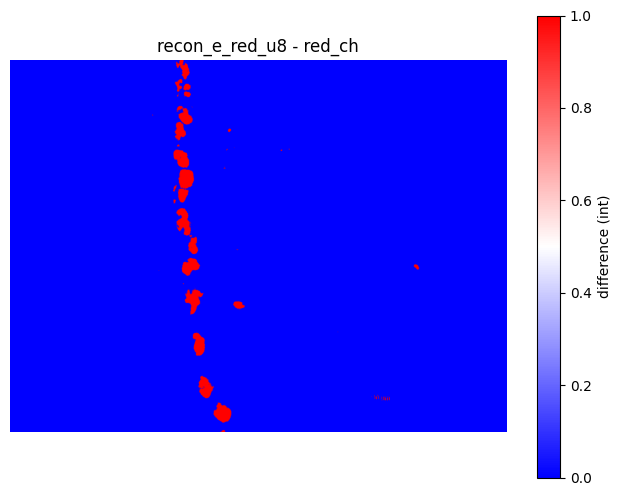

In [4]:
# show difference between recon_e_red_u8 and the original red channel (red_ch)
diff_r =  red_ch.astype(int) > recon_e_red_u8.astype(int)

print(f"diff stats: min={diff_r.min()}, max={diff_r.max()}, mean={diff_r.mean():.2f}")

plt.figure(figsize=(8, 6))
# lim = np.max(np.abs(diff_r))
# vmin, vmax = (-lim, lim) if lim > 0 else (-1, 1)
plt.imshow(diff_r, cmap="bwr")#, vmin=vmin, vmax=vmax)
plt.title("recon_e_red_u8 - red_ch")
plt.colorbar(label="difference (int)")
plt.axis("off")
plt.show()
# show where diff_r is not 0





original true pixels: 548592 / 1228800 (44.6445%)
eroded  true pixels: 449974 / 1228800 (36.6190%)


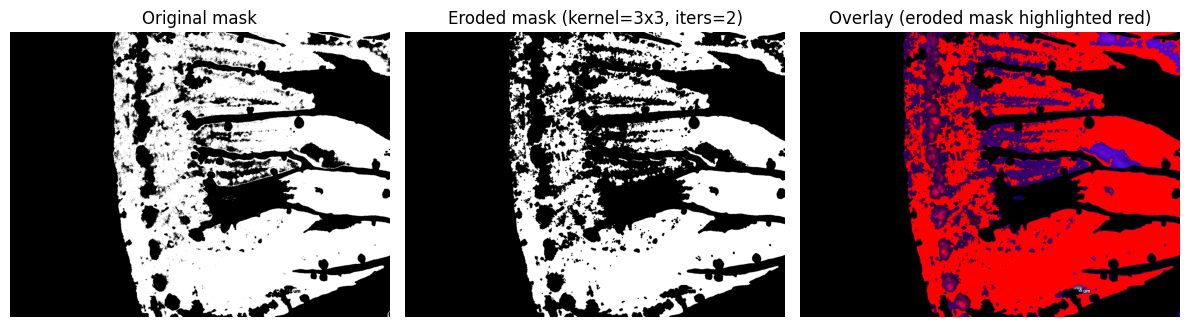

In [ ]:
# create boolean mask where abs(dilation - red) > red
abs_diff = np.abs(recon_d_red_u8.astype(int) - red_ch.astype(int))
mask_gt_red = abs_diff > red_ch.astype(int)

# quick stats
n_pixels = mask_gt_red.size
n_true = int(mask_gt_red.sum())


# erode the binary mask a bit to "shrink it back"
erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
erosion_iters = 2  # adjust if you want stronger/weaker erosion

# prepare uint8 mask for morphological ops
mask_u8 = (mask_gt_red.astype(np.uint8) * 255)
mask_eroded_u8 = cv2.erode(mask_u8, erosion_kernel, iterations=erosion_iters)
mask_gt_red_eroded = mask_eroded_u8.astype(bool)

# stats
n_true_orig = int(mask_gt_red.sum())
n_true_eroded = int(mask_gt_red_eroded.sum())
print(f"original true pixels: {n_true_orig} / {n_pixels} ({100.0 * n_true_orig / n_pixels:.4f}%)")
print(f"eroded  true pixels: {n_true_eroded} / {n_pixels} ({100.0 * n_true_eroded / n_pixels:.4f}%)")

# show original vs eroded mask
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask_gt_red, cmap="gray")
plt.title("Original mask")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_gt_red_eroded, cmap="gray")
plt.title(f"Eroded mask (kernel=3x3, iters={erosion_iters})")
plt.axis("off")

# overlay eroded mask on the RGB display (disp)
overlay_eroded = disp.copy().astype(np.uint8)
overlay_eroded[mask_gt_red_eroded, 0] = 255  # red channel
overlay_eroded[mask_gt_red_eroded, 1] = 0
overlay_eroded[mask_gt_red_eroded, 2] = 0

plt.subplot(1, 3, 3)
plt.imshow(overlay_eroded)
plt.title("Overlay (eroded mask highlighted red)")
plt.axis("off")

plt.tight_layout()
plt.show()

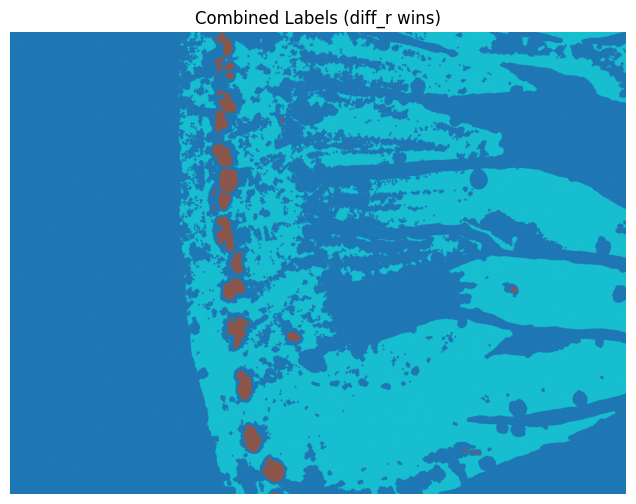

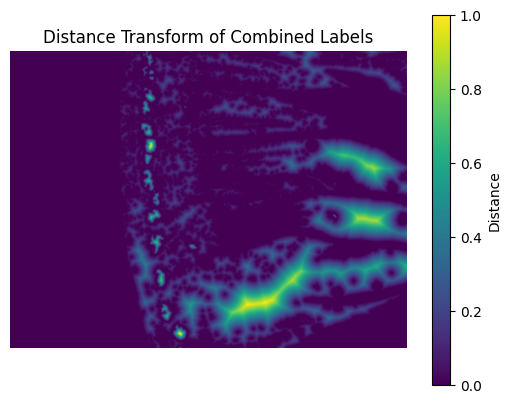

In [ ]:
import numpy as np

def minmax01(x, axis=None, eps=1e-12):
    x = np.asarray(x, dtype=float)
    lo = np.nanmin(x, axis=axis, keepdims=True)
    hi = np.nanmax(x, axis=axis, keepdims=True)
    return (x - lo) / np.maximum(hi - lo, eps)


from scipy.ndimage import distance_transform_edt

# Combine diff_r and mask_gt_red into a labeled numpy array
combined_labels = np.zeros_like(diff_r, dtype=int)

# Assign unique labels to diff_r and mask_gt_red
combined_labels[mask_gt_red_eroded] = 2  # Label for mask_gt_red
combined_labels[diff_r] = 1       # Label for diff_r (takes precedence)

# Display the combined labels
plt.figure(figsize=(8, 6))
plt.imshow(combined_labels, cmap="tab10")
plt.title("Combined Labels (diff_r wins)")
plt.axis("off")
plt.show()
# Compute the distance transform for combined_labels

# Calculate the distance transform
distance_transform =  minmax01(distance_transform_edt(combined_labels == 1)) + minmax01(distance_transform_edt(combined_labels == 2))
plt.imshow(distance_transform, cmap="viridis")
plt.title("Distance Transform of Combined Labels")
plt.colorbar(label="Distance")
plt.axis("off")
plt.show()




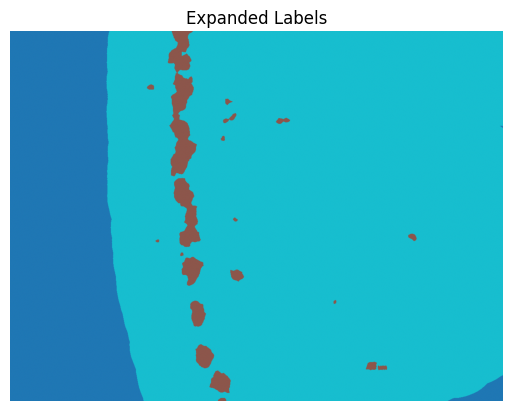

watershed labels: 131 regions (0 is background)


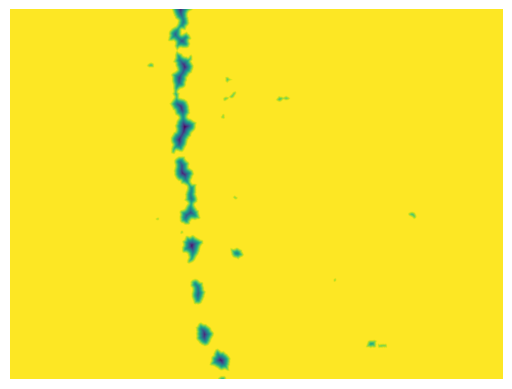

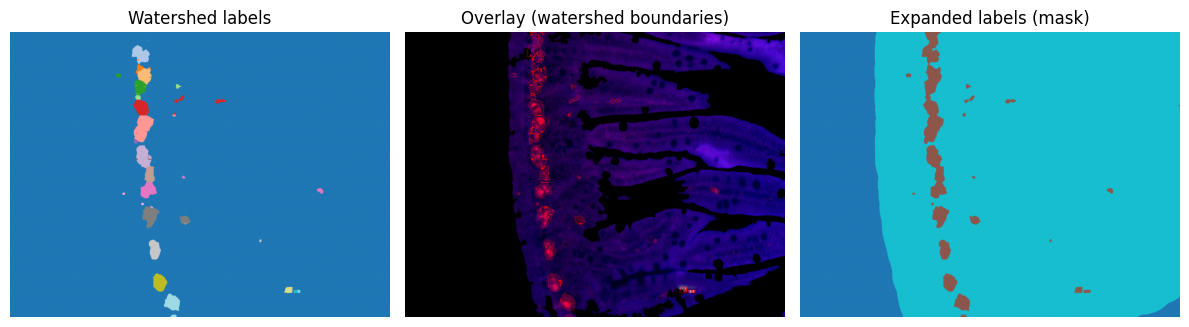

In [35]:
from skimage.segmentation import expand_labels
from skimage.segmentation import watershed, find_boundaries
from scipy.ndimage import label as ndi_label
# expand combined_labels
expanded_labels = expand_labels(combined_labels, distance=100)
plt.imshow(expanded_labels, cmap="tab10")
plt.title("Expanded Labels")
plt.axis("off")
plt.show()
# ensure we have integer markers (use existing labeled_diff_r if it contains markers)
labeled_diff_r, n_labels = ndi_label(diff_r != 0)

if np.max(labeled_diff_r) > 0:
    markers = labeled_diff_r.copy()
else:
    markers, _ = ndi_label(diff_r)

# restrict watershed to expanded regions (non-zero)
mask_ws = expanded_labels == 1

# run watershed on the elevation (float) using the markers and mask
elevation = 1-distance_transform_edt(expanded_labels==1)   # distance to nearest zero pixel (background)

ws_labels = watershed(elevation.astype(np.float32), markers=markers, mask=mask_ws)

# quick stats
uniq_ws = np.unique(ws_labels)
print(f"watershed labels: {len(uniq_ws) - (1 if 0 in uniq_ws else 0)} regions (0 is background)")

# visualize: label map and overlay boundaries on the RGB display
plt.imshow(elevation)
plt.axis("off")
plt.show()

b = find_boundaries(ws_labels, mode="inner")
overlay_ws = disp.copy()
overlay_ws[b] = [255, 0, 0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(ws_labels, cmap="tab20")
plt.title("Watershed labels")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(overlay_ws)
plt.title("Overlay (watershed boundaries)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(expanded_labels, cmap="tab10")
plt.title("Expanded labels (mask)")
plt.axis("off")

plt.tight_layout()
plt.show()


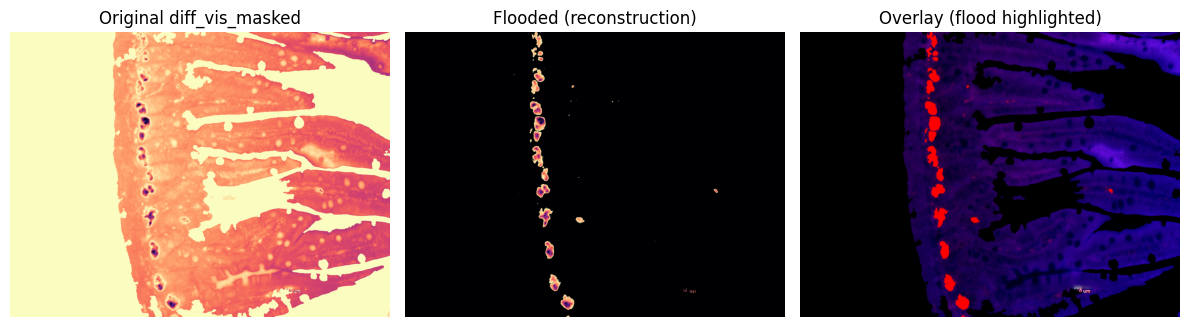

In [74]:
# use diff_r and n_true_eroded as markers, flood fill from each with mask as a limit
# select seed points from diff_r, limit to at most n_true_eroded by intensity in diff_vis_masked
seed_flat = np.flatnonzero(diff_r)
if seed_flat.size == 0:
    diff_flooded_masked = diff_vis_masked.copy()
else:
    vals = diff_vis_masked.flat[seed_flat]
    if seed_flat.size > n_true_eroded:
        # take the top n_true_eroded seeds by value
        pick_idx = np.argsort(vals)[-int(n_true_eroded):]
        sel_flat = seed_flat[pick_idx]
    else:
        sel_flat = seed_flat

    seed_mask = np.zeros(diff_r.shape, dtype=bool)
    seed_mask.flat[sel_flat] = True

    # prepare marker (seeds get their diff_vis_masked value, others set to minimum)
    marker_min = float(diff_vis_masked.min())
    marker = np.full(diff_vis_masked.shape, marker_min, dtype=diff_vis_masked.dtype)
    marker[seed_mask] = diff_vis_masked[seed_mask]

    # limit reconstruction to inside `mask` by forcing outside pixels to marker_min
    mask_limit = diff_vis_masked.copy()
    mask_limit[~mask.astype(bool)] = marker_min

    # morphological dilation reconstruction (propagates seed values up to mask_limit)
    diff_flooded_masked = reconstruction(marker, mask_limit, method="dilation")

# create an RGB overlay highlighting flooded pixels
overlay_flood = disp.copy()
fg = diff_flooded_masked > diff_flooded_masked.min()
overlay_flood[fg, 0] = 255
overlay_flood[fg, 1] = 0
overlay_flood[fg, 2] = 0

# show results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(diff_vis_masked, cmap="magma"); plt.title("Original diff_vis_masked"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(diff_flooded_masked, cmap="magma"); plt.title("Flooded (reconstruction)"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(overlay_flood); plt.title("Overlay (flood highlighted)"); plt.axis("off")
plt.tight_layout()
plt.show()